In [ ]:
import networkx as nx
import numpy as np
import collections
import matplotlib.pyplot as plt
import math
SEED=999

np.random.seed()

# 1- Preliminary part

Simulate an **epidemic** on a **symmetric k-regular undirected graph** with
node set V = {1, . . . , n} where every node is directly connected to the **k = 4** nodes whose index is closest to their own modulo n.

## 1.1.1-Generation of symmetric k-regular graph

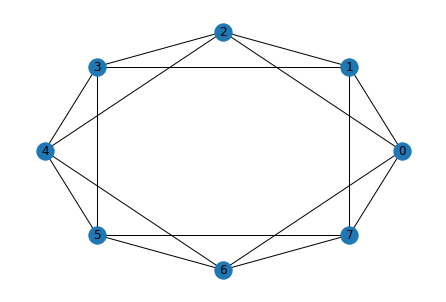

In [ ]:
def generate_symmetric_regular_graph(K=4,N=8):

  nodes = [i for i in range(N)]
  edges = [(i, j % N) for i in range(N) for j in range(i - K // 2, i + K // 2) if i != j]
  G = nx.Graph()
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)

  return G

G=generate_symmetric_regular_graph() #example
nx.draw_circular(G,with_labels=True)

## 1.1.2-Simulation of a SIR Epidemic


To simulate the epidemics we used a vector state that collects the state for each individual. The alternatives possible states are:

>**0**: Susceptible (S)

>**1**: Infected (I)

>**2**: Recovered (R)

In the following cell we declared some functions usefull to do the simulation and plotting the results, in particular:

> **creatInitialState**: initialize the first state with given  N  infected (randomly or specified).

>**getSIRcount**: return the number of S, I and R at some simulation time step.


>**countNeighbours**: return the number of infected neighbours of the given node.

>**processNextInteractions**: calculates next step in the simulation, go to the next state.

>**simulateEpidemicSIR**: simulate the epidemic model on a graph.

>**plotting functions**

In [ ]:
def createInitialState(graphSize, NInitialInfected, init_node_list = None):
    state = np.zeros(graphSize)# [0,0,0,0,0] example of 5 nodes       
    if init_node_list is not None: #we can set the infected nodes
        #foreach node, if it's cointained in the vector, set it as infected
        for i in range(graphSize): 
            if i in init_node_list:
                state[i] = 1
    else:
        #randomly infect N nodes 
        startingINodes = np.random.randint(0, graphSize, size=NInitialInfected)
        for i in range(graphSize):
            if i in startingINodes:
                state[i] = 1      
    return state #[0,0,0,1,0] example 

#Count he number of infected neighboors of a node in a particular time-step
def countNeighbours(G, node, state):
    count = 0
    for i in G.neighbors(node):
        if state[i] == 1:
            count = count + 1
    return count   

 #Use the counter to count how many S,I,R are present in the current state vector and return it as a vector
def getSIRCount(state):
    count = collections.Counter(state)
    countI = count[1]
    countR = count[2]
    countS = count[0]
    return [countS,countI,countR]

In [ ]:
#Process a new iterations (a new week) and return the new state vector, the number of new infected and the number of recovered
def processNextInteractions(G, state, beta, rho): 
    
    newInfWeekly = 0
    newRecoveredWeekly = 0
    individuals = list(G.nodes)
    np.random.shuffle(individuals)
    for node in individuals:
        if state[node] == 1: #Check if node is currently infected and can eventually recover           
            if np.random.rand() < rho: # recover the node 
                state[node] = 2
                newRecoveredWeekly += 1
        elif state[node] == 0:# Check if node is susceptible and could be infected
                m = countNeighbours(G, node, state) #Infected neighboors 
                if np.random.rand() < 1-(1-beta)**m: #infect the node with probability 1-(1-beta)*m
                    state[node] = 1
                    newInfWeekly += 1
    return state, newInfWeekly, newRecoveredWeekly

In [ ]:
#Wrap all the previous function and run the simulation, start with a fixed number of infected (n_patients_zero) randomly selected.
def simulateEpidemicSIR(G,n_simulation=100,n_week=15,n_patients_zero=10,beta=0.3,rho=0.7):

  sim_w_avg_rec=[] #simulation data
  sim_w_avg_inf=[]
  sim_w_avg_sir=[]

  prevState=[]
  for sim in range(n_simulation):
      week_avg_rec=[] #weekly data
      week_avg_inf=[]
      week_avg_sir=[]
      
      for week in range(0,n_week):
          if week==0: #first time-step 
              prevState=createInitialState(len(G),n_patients_zero)#randomly infect n_patiens_zero agents
              week_avg_inf.append(n_patients_zero)# save weekly data
              week_avg_rec.append(0)
              week_avg_sir.append(getSIRCount(prevState))
          else:
              state=processNextInteractions(G,prevState,beta,rho) #process the state, go to the next state
              week_avg_inf.append(state[1]) #save new weekly infected
  
              week_avg_rec.append(state[2]) #save new weekly recovered
              week_avg_sir.append(getSIRCount(state[0])) #get actual week total number of susceptible, infected and recovered
              prevState=state[0] #update the state
      
      sim_w_avg_inf.append(week_avg_inf) #save data of each week
      sim_w_avg_rec.append(week_avg_rec)
      sim_w_avg_sir.append(week_avg_sir)

  return sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_sir

def plot_new_avg_state(sim_w_avg_inf,sim_w_avg_vac=None):
  
  n_simulation=len(sim_w_avg_inf)
  n_week=len(sim_w_avg_inf[0])
  title=f"Average on {n_simulation} simulation of: new Infected over {n_week} weeks"
  plotValue = np.mean(sim_w_avg_inf,axis=0) #get mean for each week over the simulations
  #plotValue2= np.mean(sim_w_avg_rec,axis=0)

  
  

  plt.plot(plotValue, marker='x', label='I')
  #plt.plot(plotValue2,marker='x', label='R')

  if sim_w_avg_vac!=None:
    plotValue3=np.mean(sim_w_avg_vac,axis=0)
    plt.plot(plotValue3, marker='x', label='V')
    title=f"Average on {n_simulation} simulation of: new Infected and new Vaccinated over {n_week} weeks"

  plt.xlabel("N° Weeks", fontsize=12)
  plt.ylabel("AVG(new individuals)", fontsize=12)
  plt.title(title, fontsize=14)
  plt.legend()




def plot_tot_avg_sir(sim_w_avg_sir,sirv=False):
  
  weekly_average_SIR = np.mean(sim_w_avg_sir, axis=0) #get mean for each week over the simulations
  n_simulation=len(sim_w_avg_sir)
  n_week=len(sim_w_avg_inf[0])
  title=f"Average on {n_simulation} simulation of total: Suscettible, Infected and Recovered over {n_week} weeks"

  plt.plot(weekly_average_SIR[:,0], marker='x', label='S')
  plt.plot(weekly_average_SIR[:,1], marker='x', label='I')
  plt.plot(weekly_average_SIR[:,2], marker='x', label='R')
  if sirv:
    plt.plot(weekly_average_SIR[:,3], marker='x', label='V')
    title=f"Average on {n_simulation} simulation of total: Suscettible, Infected, Recovered and Vaccinated over {n_week} weeks"

  plt.xlabel("N° Week", fontsize=14)
  plt.ylabel("AVG(tot individuals)", fontsize=14)
  plt.title(title, fontsize=18)
  plt.legend()


##1.1.3-Problem: simulate epidemic on a known graph
You should simulate an epidemic on a **symmetric k-regular** graph G = (V, E)
with **|V| = 500** nodes and **k = 4**. See [this cell](https://colab.research.google.com/drive/1LZk1ZWcG263jE0BxXoosNfqAgrKNv-G7#scrollTo=9JZ7efeaNX5X&line=1&uniqifier=1) for an example with n = 8 nodes. 

Let **β = 0.3** and **ρ = 0.7**. 

With one week being one unit of time, simulate the epidemic for **15 weeks**. You
can choose an initial configuration with **10 infected nodes** selected at random from the nodeset V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

Do this **N = 100** times and plot the following:
> 1.  The average number of newly infected individuals each week. In other words, you should plot how many people become infected each week (on the average).
> 2. The average total number of susceptible, infected, and recovered individuals at each
week. 
In other words, you should plot how many individuals in total that are susceptible/infected/recovered at each week (on the average).
### Solution

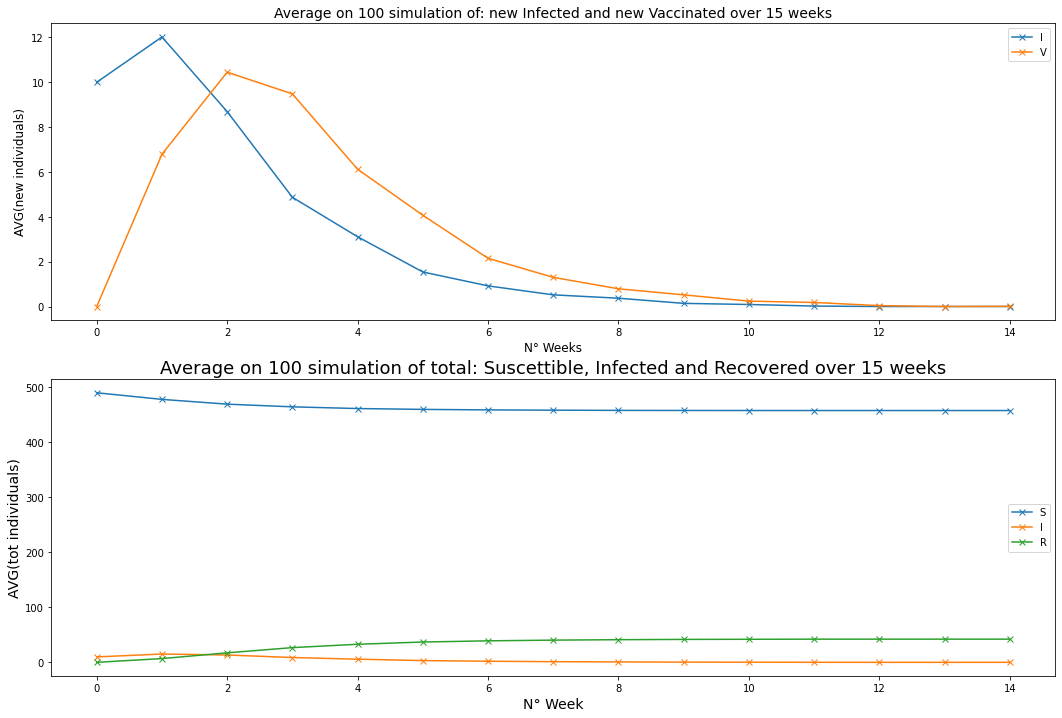

In [ ]:

G=generate_symmetric_regular_graph(4,500) #symmetryc regular graph 500 node deegre 4
sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_sir=simulateEpidemicSIR(G)

fig=plt.figure(figsize=(18,12))
plt.subplot(211)
plot_new_avg_state(sim_w_avg_inf,sim_w_avg_rec)#Question 1
plt.subplot(212)
plot_tot_avg_sir(sim_w_avg_sir)#Question 2


## 1.2-Problem: Generate a random graph 
According to the node *preferential attachement model* generate a random graph.

Your goal is to, by using preferential attachment, generate a random graph
of a large size (at least 900 nodes) with average degree $k ∈ {Z_+}$. 

Let the initial graph
$G1 = (V1, E1)$ be a complete graph with $|V1| = k0 = k + 1$ nodes.

###Solution
At each iteration, a new node  $n_t$  is added to the existing graph and it links with  $c=\frac{k}{2}$  existing nodes. 

Nodes with relative higher degree in the graph are consequently more likely to be linked to  $n_t$ 

For each iteration, add  **cundirectedlinks**  to the existing graph. 
If **k is odd** alternating between adding **floor(k/2)** and **ceil(k/2)** links when adding a new node to the graph. 

Then I choose  C  nodes to link the new node.  

**Replace=False**  is used to link each node just once.


In [ ]:
def generateRanGraphK(GSize, k):
    RandomG = nx.complete_graph(k + 1) #Start with complete graph
    for nt in range(len(RandomG.nodes), GSize):
        probabilities = []
        RandomG.add_node(nt)
        c = (k + (nt % 2)) // 2
        totalDegree = np.array(RandomG.degree()).sum(axis=0)[1]
        
        for node in RandomG.nodes():
            probabilities.append(RandomG.degree[node]/totalDegree)
        selNodes = np.random.choice(RandomG.nodes(), p=probabilities, size=int(c), replace=False)
        for cn in selNodes:
            RandomG.add_edge(nt, cn)
    return RandomG

The above function generate graph with average deegre specified as parameter.
In the following example we have 4 nodes:

**Degree of each node:**  $[1,3,2,2]$

**Average deegre:**  $\frac{(1+3+2+2)}{4}=2$

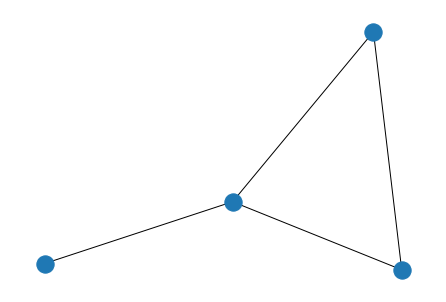

In [ ]:
G=generateRanGraphK(4,2)
nx.draw_spring(G)

# 2-Simulate pandemic without vaccination

##2-Problem: simulate a pandemic without vaccination on a random graph
Using the methods developed in Section 1, generate a **preferential attachment
random graph** graph G = (V, E)
with **|V| = 500** nodes and **k = 6**. See [the above cell](https://colab.research.google.com/drive/1LZk1ZWcG263jE0BxXoosNfqAgrKNv-G7#scrollTo=9JZ7efeaNX5X&line=1&uniqifier=1) for an example with k=2. 

Let **β = 0.3** and **ρ = 0.7**. 

With one week being one unit of time, simulate the epidemic for **15 weeks**. You
can choose an initial configuration with **10 infected nodes** selected at random from the nodeset V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

Do this **N = 100** times and plot the following:
> 1.  The average number of newly infected individuals each week. In other words, you should plot how many people become infected each week (on the average).
> 2. The average total number of susceptible, infected, and recovered individuals at each
week. 
In other words, you should plot how many individuals in total that are susceptible/infected/recovered at each week (on the average).
### Solution

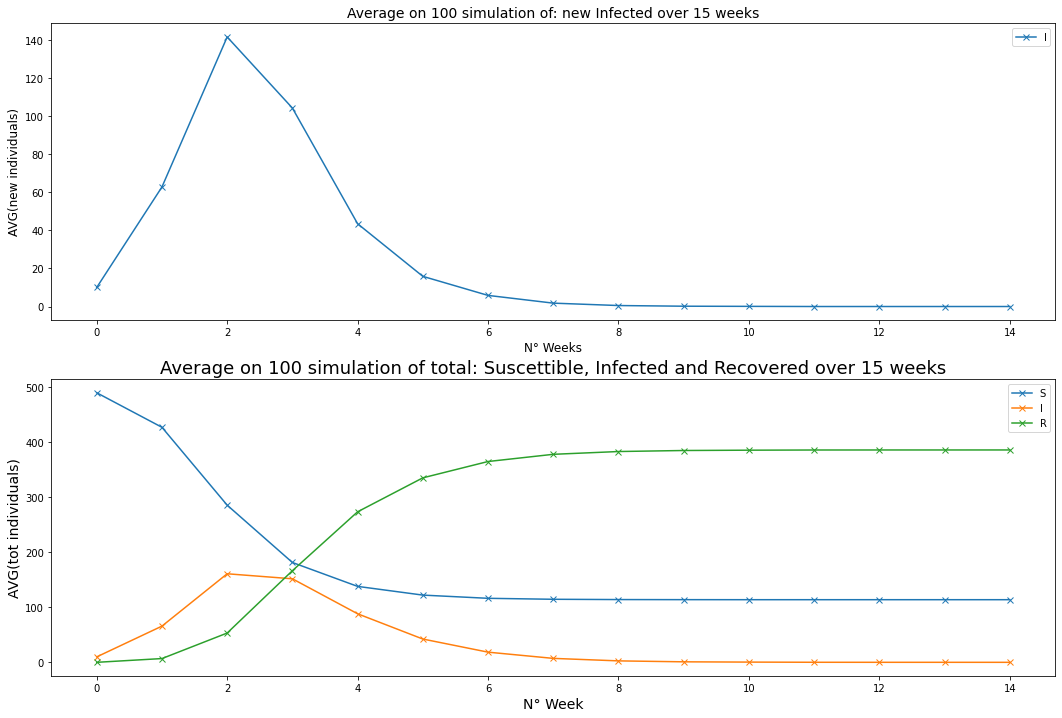

In [ ]:
G = generateRanGraphK(500, 6)
sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_sir=simulateEpidemicSIR(G)

fig=plt.figure(figsize=(18,12))
plt.subplot(211)
plot_new_avg_state(sim_w_avg_inf)
plt.subplot(212)
plot_tot_avg_sir(sim_w_avg_sir)

#3-Simulate pandemic with vaccination

We try to take some action to slow down the epidemic. This is normally done using vaccination. Therefore, during
each week, some parts of the population will receive vaccination. **Once a person is vaccinated it cannot be infected and cannot infect any other individuals.** Furthermore, **the vaccination is assumed to take effect immediately once given**.

The total fraction of population that has received vaccination by each week is according to:

>$$Vacc(t) = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]$$
$Vacc(t)$ should be interpreted as: 55% of the population has received vaccination by week 7, and 5% received vaccination during week 7.

We need to find the correct number of individuals to vaccinate according to $Vacc(t).$
These individuals should be selected uniformly at random from the population
that has not yet received vaccination. 

**An infected individual might receive vaccination as well.**  
If an infected individual becomes vaccinated it is assumed that he/she will not be able to infect another individual. 

In other words, we assume that **regardless of the state of an individual prior to the vaccination, once vaccinated
the individual will not be able to become infected nor infect any other individuals.**

We model the possibility to vaccinate recovered individuals.
The boolean **vaccineRecovered** corrispond to the possibility of vaccinating the recovered individuals or not.
This is related to the possibility of choosing if vaccinate or not individuals that have generate antibodies.

>**The state for vaccinated is 3**

In the following cell we declared some functions usefull to do the simulation and plotting the results, in particular:

> **processVaccination**: vaccinate the population based on the given data $Vacc(t)$.

>**getSIRcountV**: return the number of S, I, R and V at some simulation time step.

>**simulateEpidemicSIRV**: simulate the epidemic model on a graph




In [ ]:
def getSIRCountV(myState):
    count = collections.Counter(myState)
    countI = count[1]
    countR = count[2]
    countV = count[3]
    countS = count[0]
    return [countS,countI,countR,countV]

def processVaccination(RG, w, state, vaccT, vaccineRecovered=True):
    nToBeVaccinated = len(RG.nodes)*(vaccT[w]/100.0)
    
    if vaccineRecovered == True: #if we want to vaccine recovered people
        potentialndivVaccine = list(np.where(state != 3)[0])  
    else:
        potentialndivVaccine = list(np.where(state==0)[0]) + list(np.where(state==1)[0])
    if nToBeVaccinated > len(potentialndivVaccine): #if we can give vaccine to all the potential individuals
        nToBeVaccinated = len(potentialndivVaccine)        
    IndividualsToVaccinate = list(np.random.choice(potentialndivVaccine, size=int(nToBeVaccinated), replace=False))
    for ind in IndividualsToVaccinate: #set the vaccinated individuals state to "3"
        state[ind] = 3    
    return state, nToBeVaccinated

#TO DO
def simulateEpidemicSIRV(G,vaccPerc,v_recovered=True,n_simulation=100,n_week=15,n_patients_zero=10,beta=0.3,rho=0.7):


  vaccT=[]#Convert percentage of population to difference (see text above)
  vaccT.append(vaccPerc[0]-0)
  for i in range(1,len(vaccPerc)):
    vaccT.append(vaccPerc[i]-vaccPerc[i-1])
  #print(vaccT)
  sim_w_avg_rec=[] #simulation data
  sim_w_avg_inf=[]
  sim_w_avg_vac=[]
  sim_w_avg_sirv=[]

  prevState=[]
  for sim in range(n_simulation):
      week_avg_rec=[] #weekly data
      week_avg_inf=[]
      week_avg_vac=[]
      week_avg_sirv=[]
      
      for week in range(0,n_week):
          if week==0: #first time-step 
              prevState=createInitialState(len(G),n_patients_zero)#randomly infect n_patiens_zero agents
              week_avg_inf.append(n_patients_zero)# save weekly data
              week_avg_rec.append(0)
              week_avg_vac.append(0)
              week_avg_sirv.append(getSIRCountV(prevState))
          else:
              #process vaccination
              vstate, newWeeklyVacc = processVaccination(G, week, prevState, vaccT, vaccineRecovered=v_recovered)
              state=processNextInteractions(G,vstate,beta,rho) #process the state, go to the next state
              week_avg_inf.append(state[1]) #save new weekly infected
              week_avg_vac.append(newWeeklyVacc)#save new weekly vaccinated
              week_avg_rec.append(state[2]) #save new weekly recovered
              week_avg_sirv.append(getSIRCountV(state[0])) #get actual week total number of susceptible, infected and recovered
              prevState=state[0] #update the state
      
      sim_w_avg_inf.append(week_avg_inf) #save data of each week
      sim_w_avg_rec.append(week_avg_rec)
      sim_w_avg_sirv.append(week_avg_sirv)
      sim_w_avg_vac.append(week_avg_vac)

  return sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_vac,sim_w_avg_sirv

##3.1-Problem: simulation whit vaccinate recovered

We can see that the max of new infected is 90 in the second week respect to 150 in the case without vaccination,
the pandemic spreads less.

Moreover the number of recovered is lower with vaccination, this can be interpretated as less pressure on the sanitary system.

In the following simulation we chose to vaccinate recovered individuals.

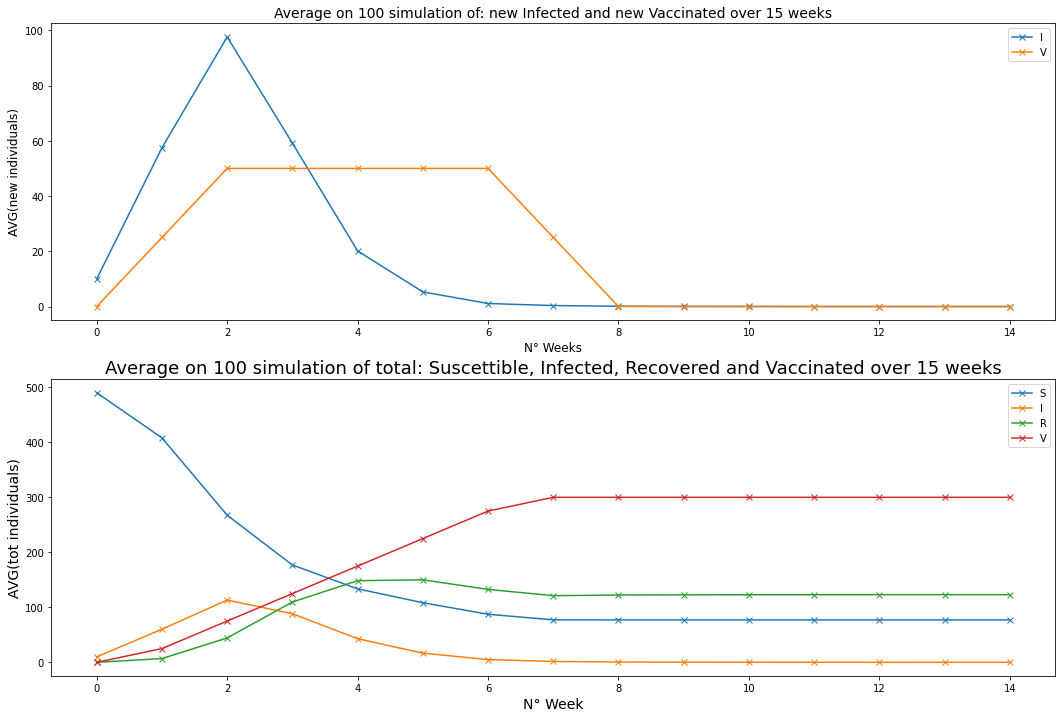

In [ ]:
vaccPerc=[0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]

G = generateRanGraphK(500, 6)
sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_vac,sim_w_avg_sirv=simulateEpidemicSIRV(G,vaccPerc,v_recovered=True)

fig=plt.figure(figsize=(18,12))
plt.subplot(211)
plot_new_avg_state(sim_w_avg_inf,sim_w_avg_vac)
plt.subplot(212)
plot_tot_avg_sir(sim_w_avg_sirv,sirv=True)

##3.2-Problem: simulation whitout vaccinate recovered

If we decide to no vaccinate the recovered individuals, we can see that the new recovered go to zero fastly in the fifth week we have some recovered individual less.

This analisys can be used to make decision in order to prioritizing the vaccination campaign.

Since in our model recovered individuals cant become re-infected prioritizing the vaccination of not recovered individuals can reduce the number of recovered.

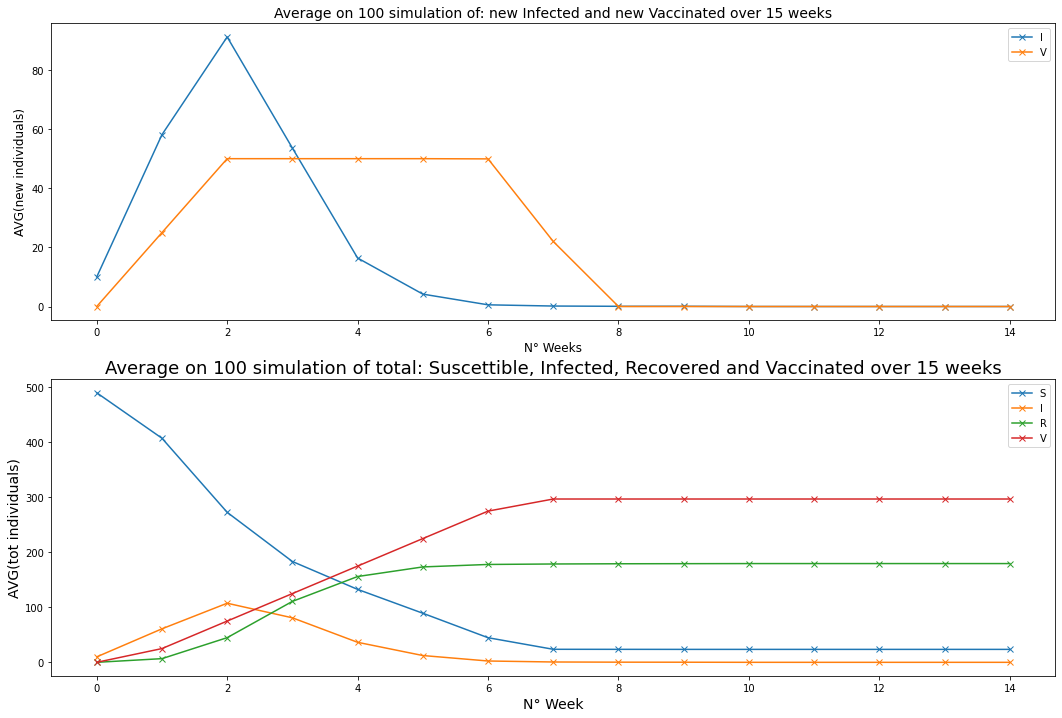

In [ ]:
sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_vac,sim_w_avg_sirv=simulateEpidemicSIRV(G,vaccPerc,v_recovered=False)

fig=plt.figure(figsize=(18,12))
plt.subplot(211)
plot_new_avg_state(sim_w_avg_inf,sim_w_avg_vac)
plt.subplot(212)
plot_tot_avg_sir(sim_w_avg_sirv,sirv=True)

#4-The H1N1 pandemic in Sweden 2009

We will simulate the pandemic between week 42, 2009 and week 5, 2010. During these weeks,
the fraction of population that had received vaccination was:
$$Vacc(t) = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]$$

The population of Sweden is scaled down by a factor of $10^4$.

So the number of individuals is $n = |V| = 934$.

For the scaled version, the number of newly infected individuals each of **16 week** was:
$$I_0(t) = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]$$

The following algorithm will do a search over the parameter space of k, β,
and ρ in order to find the set of parameters that best matches the real pandemic.


In [ ]:
vaccPerc=[5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]

InitialSt = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

NSteps = 10
NWeeks = 15+1
nInitialInfe = InitialSt[0]

deK = 1
deBeta = 0.1 
deRho = 0.1

GSize = 934

configuration = None
best_configuration = {"k" : 10, "beta": 0.3, "rho": 0.6}
#best_configuration = {'k': 11, 'beta': 0.09999999999999998, 'rho': 0.5}
RMSE_best = np.inf


while configuration!=best_configuration:
  configuration=best_configuration


    #Values
  RMSEs = []
  configurations = []
  avgs_new_infected = []
  avgs_new_recovered = []
  avgs_new_vaccinated = []
  SIRVs = []

  #Initialize config
  startK = configuration["k"]
  startB = configuration["beta"]
  startR = configuration["rho"]

  #Values spectrum
  Kvals = [startK - deK, startK, startK + deK]
  Betavals = [startB - deBeta, startB, startB + deBeta]
  Rhovals = [startR - deRho, startR, startR + deRho]
      

  for k in Kvals:
      RG = generateRanGraphK(GSize, k)
      for beta in Betavals:
          for rho in Rhovals:
              sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_vac,sim_w_avg_sirv=simulateEpidemicSIRV(RG,vaccPerc,v_recovered=True,n_simulation=10,n_week=NWeeks,n_patients_zero=1,beta=beta,rho=rho)
              #AvfNewInf, all_steps_SIRV = Simulate(RG, NSteps, NWeeks, nInitialInfe, beta, rho, vaccT) #Run the simulation with the current parameters
              I = np.mean(sim_w_avg_inf, axis=0)
              V = np.mean(sim_w_avg_vac, axis=0)
              R = np.mean(sim_w_avg_rec, axis=0)
              
              RMSE = math.sqrt(((InitialSt - I)**2).mean())
              RMSEs.append(RMSE)
              avgs_new_infected.append(I)
              avgs_new_vaccinated.append(V)
              avgs_new_recovered.append(R)
              SIRVs.append(sim_w_avg_sirv)
              configurations.append({"k": k, "beta": beta, "rho": rho})

  smallestRMSE = np.min(RMSEs)

  #Check if we found a better config based on the RMSE
  if smallestRMSE < RMSE_best: 
      RMSE_best = smallestRMSE
      best_configuration = configurations[np.argmin(RMSEs)]
      best_avg_new_infected = avgs_new_infected[np.argmin(RMSEs)]
      best_avg_new_vaccinated = avgs_new_vaccinated[np.argmin(RMSEs)]
      best_avg_new_recovered = avgs_new_recovered[np.argmin(RMSEs)]
      best_all_steps_SIRV = SIRVs[np.argmin(RMSEs)]
      print(f"New RMSE {RMSE_best} -->  Params: {best_configuration}")
  
print("Model new infected per week:",best_avg_new_infected)

New RMSE 22.18973580284362 -->  Params: {'k': 10, 'beta': 0.19999999999999998, 'rho': 0.7}
New RMSE 9.878258955909184 -->  Params: {'k': 10, 'beta': 0.09999999999999998, 'rho': 0.6}
New RMSE 9.801753669624635 -->  Params: {'k': 11, 'beta': 0.09999999999999998, 'rho': 0.7}
New RMSE 9.671672554424081 -->  Params: {'k': 12, 'beta': 0.09999999999999998, 'rho': 0.7}
New RMSE 9.17595362891509 -->  Params: {'k': 11, 'beta': 0.09999999999999998, 'rho': 0.6}
New RMSE 9.128218610440923 -->  Params: {'k': 12, 'beta': 0.09999999999999998, 'rho': 0.5}
New RMSE 8.359164132854433 -->  Params: {'k': 11, 'beta': 0.09999999999999998, 'rho': 0.5}
New RMSE 7.215218291916052 -->  Params: {'k': 12, 'beta': 0.09999999999999998, 'rho': 0.4}
Model new infected per week: [ 1.   0.8  1.6  8.5 16.5 17.9 17.1 11.1  7.   4.4  1.4  1.2  0.8  0.9
  0.5  0.6]


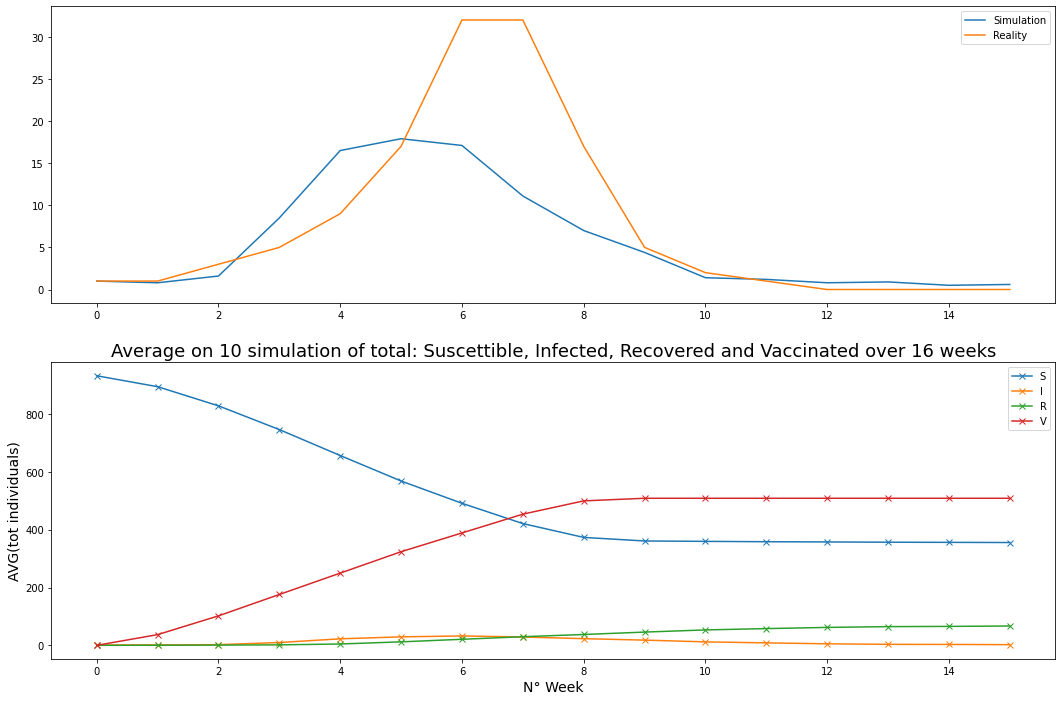

In [ ]:
fig=plt.figure(figsize=(18,12))
plt.subplot(211)

plt.plot(best_avg_new_infected,label="Simulation")
plt.plot(InitialSt,label="Reality")
plt.legend()
plt.subplot(212)
plot_tot_avg_sir(best_all_steps_SIRV,sirv=True)

#5-Challenge (optional)


Try to find a better random graph (i.e. one that does not use preferential attachment) to
represent the network for the pandemic. Try to also find a better algorithm to estimate the
parameters.




##5.1-The Erdos-Renyi model

We perform an additional simulation with another random graph: the Erdos-Renyi model, this is a well known random graph used in the context of epidemic simulation, we can set the parameter k that is used to computer the probability of having an edge between couple of different nodes. 


**NOTE:** in order to generate the Erdos-Renyi graph, we use networkx but since we want to set k (average degree) we wrap the function, we compute p starting from k and then we use the library function.

In [ ]:
from scipy import special
#avg(deg)=p*(n-1)
def generate_ER(N, k):
  p = k/(N-1)# compute p starting from k (average degree)
  #print(p)
  # add links between couple of different nodes with probability p
  GER = nx.erdos_renyi_graph(N, p, directed=False)
  return GER

In [ ]:
GER=generate_ER(G.number_of_nodes(),3)
nx.draw_circular(GER,node_size=[1.2 for _ in GER.nodes()])
print(f"Numerical average degree of the graph {np.mean(list(dict(GER.degree()).values()))}")

##5.2-Simulation on Erdos-Reniy model

With this model we find a new best RMSE equal to 6.85 respect the previous RMSE equal to 7.21, we can conclude that the Erdos-Reniy model fit better respect to the random graph with preferential attachment.

In [ ]:
vaccPerc=[5,9,16,24,32,40,47,54,59,60,60,60,60,60,60,60]

InitialSt = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

NSteps = 10
NWeeks = 15+1
nInitialInfe = InitialSt[0]

deK = 1
deBeta = 0.1 
deRho = 0.1

GSize = 934

configuration = None
best_configuration = {"k" : 10, "beta": 0.3, "rho": 0.6}
#best_configuration = {'k': 11, 'beta': 0.09999999999999998, 'rho': 0.5}
RMSE_best = np.inf


while configuration!=best_configuration:
  configuration=best_configuration


    #Values
  RMSEs = []
  configurations = []
  avgs_new_infected = []
  avgs_new_recovered = []
  avgs_new_vaccinated = []
  SIRVs = []

  #Initialize config
  startK = configuration["k"]
  startB = configuration["beta"]
  startR = configuration["rho"]

  #Values spectrum
  Kvals = [startK - deK, startK, startK + deK]
  Betavals = [startB - deBeta, startB, startB + deBeta]
  Rhovals = [startR - deRho, startR, startR + deRho]
      

  for k in Kvals:
      RG = generate_ER(GSize, k)
      for beta in Betavals:
          for rho in Rhovals:
              sim_w_avg_inf,sim_w_avg_rec,sim_w_avg_vac,sim_w_avg_sirv=simulateEpidemicSIRV(RG,vaccPerc,v_recovered=True,n_simulation=10,n_week=NWeeks,n_patients_zero=1,beta=beta,rho=rho)
              #AvfNewInf, all_steps_SIRV = Simulate(RG, NSteps, NWeeks, nInitialInfe, beta, rho, vaccT) #Run the simulation with the current parameters
              I = np.mean(sim_w_avg_inf, axis=0)
              V = np.mean(sim_w_avg_vac, axis=0)
              R = np.mean(sim_w_avg_rec, axis=0)
              
              RMSE = math.sqrt(((InitialSt - I)**2).mean())
              RMSEs.append(RMSE)
              avgs_new_infected.append(I)
              avgs_new_vaccinated.append(V)
              avgs_new_recovered.append(R)
              SIRVs.append(sim_w_avg_sirv)
              configurations.append({"k": k, "beta": beta, "rho": rho})

  smallestRMSE = np.min(RMSEs)

  #Check if we found a better config based on the RMSE
  if smallestRMSE < RMSE_best: 
      RMSE_best = smallestRMSE
      best_configuration = configurations[np.argmin(RMSEs)]
      best_avg_new_infected = avgs_new_infected[np.argmin(RMSEs)]
      best_avg_new_vaccinated = avgs_new_vaccinated[np.argmin(RMSEs)]
      best_avg_new_recovered = avgs_new_recovered[np.argmin(RMSEs)]
      best_all_steps_SIRV = SIRVs[np.argmin(RMSEs)]
      print(f"New RMSE {RMSE_best} -->  Params: {best_configuration}")
  
print("Model new infected per week:",best_avg_new_infected)

New RMSE 6.852189431123457 -->  Params: {'k': 11, 'beta': 0.19999999999999998, 'rho': 0.5}
Model new infected per week: [ 1.   1.4  3.2  7.7 19.6 38.1 35.5 26.2 11.9  7.2  7.4  6.9  5.1  3.6
  1.9  1.7]


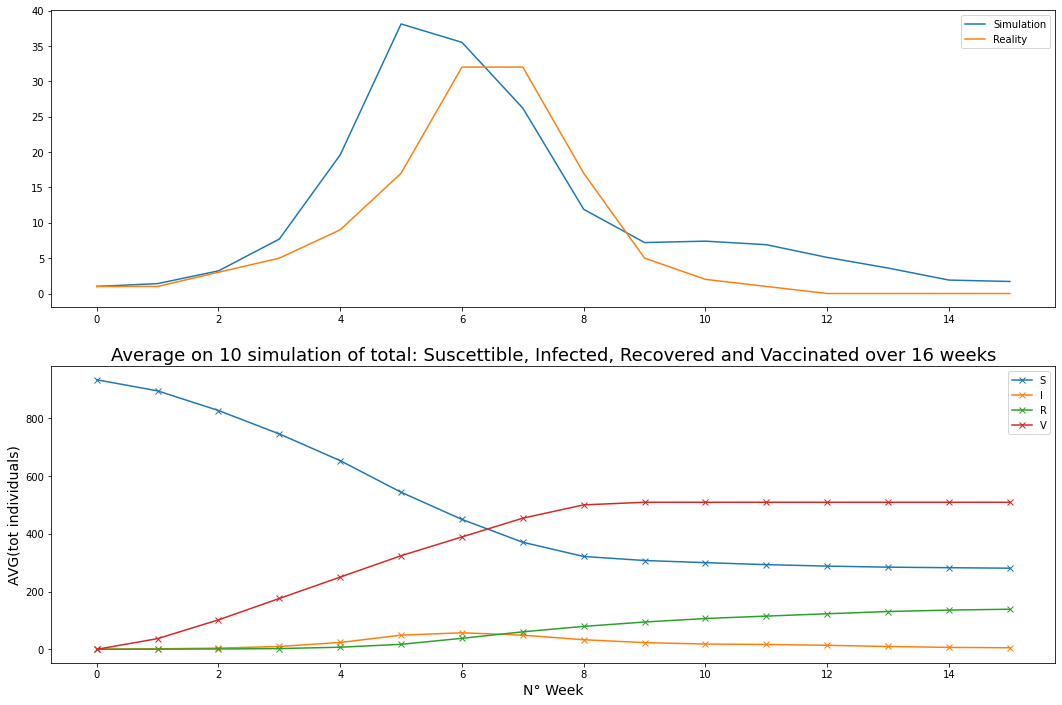

In [ ]:
fig=plt.figure(figsize=(18,12))
plt.subplot(211)

plt.plot(best_avg_new_infected,label="Simulation")
plt.plot(InitialSt,label="Reality")
plt.legend()
plt.subplot(212)
plot_tot_avg_sir(best_all_steps_SIRV,sirv=True)